In [1]:
import qiskit
import qc_grader

In [2]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'CHNKkTAi3-CIvLMGJZaPIbeXu0j3gxd9IpdfgGPkbBV5',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/87b24589a3b44152b6a85acf9096729f:8ceba6f0-906a-4363-bda9-f5ad62faaca5::',
  'verify': True,
  'private_endpoint': False}}

In [3]:
# Import common packages first
import numpy as np

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Import utils and cosystems
from lab4_util import hamming_distance, minimum_distance, bring_states, matrixRank
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2  as Sampler

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab4_ex1, 
    grade_lab4_ex2, 
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6
)

In [4]:
# Example usage:
str1 = "10110"
str2 = "11100"
dist = hamming_distance(str1, str2)
print(f"Hamming distance between '{str1}' and '{str2}' is: {dist}") # Output: 2

vec1 = [1, 0, 0, 1]
vec2 = [0, 0, 1, 1]
dist_vec = hamming_distance(vec1, vec2)
print(f"Hamming distance between {vec1} and {vec2} is: {dist_vec}") # Output: 2

Hamming distance between '10110' and '11100' is: 2
Hamming distance between [1, 0, 0, 1] and [0, 0, 1, 1] is: 2


In [5]:
# --- Example: A Simple [4, 3, 2] Parity Check Code ---
# This code takes 3 message bits (k=3) and adds an even parity bit
# to make the total codeword length n=4.
# Messages: 000, 001, 010, 011, 100, 101, 110, 111
# Codewords (adding even parity bit):
parity_code_4_3 = [
    "0000", # 000 + 0 (even parity)
    "0011", # 001 + 1
    "0101", # 010 + 1
    "0110", # 011 + 0
    "1001", # 100 + 1
    "1010", # 101 + 0
    "1100", # 110 + 0
    "1111"  # 111 + 1
]

# Calculate the minimum distance d
d_parity = minimum_distance(parity_code_4_3)
print(f"Codewords: {parity_code_4_3}")
print(f"Calculated minimum distance d = {d_parity}") # Output: 2

Codewords: ['0000', '0011', '0101', '0110', '1001', '1010', '1100', '1111']
Calculated minimum distance d = 2


In [6]:
# --- Example: [3, 1, 3] Repetition Code ---
repetition_code_3_1 = ["000", "111"]
d_repetition = minimum_distance(repetition_code_3_1)
print(f"Calculated minimum distance d = {d_repetition}") # Output: 3

# Capabilities for d=3:
t_detect = d_repetition - 1
t_correct = int((d_repetition - 1) / 2) // 1
print(f"Error Detection Capability (t_detect = d-1): {t_detect}") # Output: 2
print(f"Error Correction Capability (t_correct = floor((d-1)/2)): {t_correct}") # Output: 1

Calculated minimum distance d = 3
Error Detection Capability (t_detect = d-1): 2
Error Correction Capability (t_correct = floor((d-1)/2)): 1


In [7]:
test_str = "010"

print("Hamming distance between 010 and 000 is", hamming_distance(test_str, "000"))
print("Hamming distance between 010 and 111 is", hamming_distance(test_str, "111"))

Hamming distance between 010 and 000 is 1
Hamming distance between 010 and 111 is 2


In [8]:
hardcode_decoder_3_1_3 ={
    '000': '0',
    '001': '',
    '010': '',
    '011': '',
    '100': '',
    '101': '',
    '110': '',
    '111': '1'}

In [9]:
hardcode_decoder_bit_flip_syndrome_map = {
    # ---- TODO : Task 1 ---
    # Fill in the other entries of the decoder (leave the "" in place).
    #{"s1s0": "Error Code"}
    '00': 'I',
    '01': 'X2',             
    '10': 'X0',            
    '11': 'X1'     
    # --- End of TODO ---         
}

In [10]:
grade_lab4_ex1(hardcode_decoder_bit_flip_syndrome_map )

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [37]:
# ---- TODO : Task 2 ---
# Fill in the other error codes
# Define stabilizers as bit patterns: each list is a row of H
H = [
    [1, 1, 1, 1, 0, 0, 0],  # S0: X-type (X0 X1 X2 X3)
    [1, 1, 0, 0, 1, 1, 0],  # S1: X-type (X0 X1 X4 X5)
    [1, 0, 1, 0, 1, 0, 1],  # S2: X-type (X0 X2 X4 X6)
]

def get_syndrome(pauli: str, qubit: int):
    # Initialize 6-bit syndrome: [s5, s4, s3, s2, s1, s0]
    syndrome = [0]*6

    for i in range(3):  # X-type stabilizers → check for Z, Y
        if pauli in ('Z', 'Y') and H[i][qubit] == 1:
            syndrome[i] = 1

    for i in range(3):  # Z-type stabilizers → check for X, Y
        if pauli in ('X', 'Y') and H[i][qubit] == 1:
            syndrome[i+3] = 1

    return ''.join(str(s) for s in reversed(syndrome))  # s5...s0

# Build the complete map
steane_decoder_syndrome_map = {
    "000000": "I"
}

for q in range(7):
    for p in ["X", "Y", "Z"]:
        s = get_syndrome(p, q)
        steane_decoder_syndrome_map[s] = f"{p}{q}"

# --- End of TODO ---

In [38]:
grade_lab4_ex2(steane_decoder_syndrome_map)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [39]:
def measure_steane_syndrome(qc, q_data, q_anc, c_reg):

    # Measure X-type Stabilizers (S0, S1, S2 -> q_anc[0], q_anc[1], q_anc[2])
    # Apply H to data qubits -> CNOT -> Apply H to data qubits -> Measure ancilla
    qc.h(q_data) # H on data qubits

    #S0: IIIXXXX (X_3 X_2 X_1 X_0)
    qc.cx(q_data[0], q_anc[0])
    qc.cx(q_data[1], q_anc[0])
    qc.cx(q_data[2], q_anc[0])
    qc.cx(q_data[3], q_anc[0])

    # ---- TODO : Task 3 ---
    # Fill in the required code for S1 and S2
    #S1
    qc.cx(q_data[0], q_anc[1])
    qc.cx(q_data[1], q_anc[1])
    qc.cx(q_data[4], q_anc[1])
    qc.cx(q_data[5], q_anc[1])
    #S2
    qc.cx(q_data[0], q_anc[2])
    qc.cx(q_data[2], q_anc[2])
    qc.cx(q_data[4], q_anc[2])
    qc.cx(q_data[6], q_anc[2])
    # --- End of TODO ---

    qc.h(q_data) # Restore H on data qubits
    qc.measure(q_anc[0:3], c_reg[0:3]) # Measure X syndrome (s1, s2, s3)
    qc.barrier()


    # ---- TODO : Task 3 ---
    # Measure Z-type Stabilizers (S3, S4, S5 -> q_anc[3], q_anc[4], q_anc[5])
    # CNOT -> Measure ancilla    
    # Fill in the required code for S3, S4 and s5

    #S3
    qc.cx(q_data[0], q_anc[3])
    qc.cx(q_data[1], q_anc[3])
    qc.cx(q_data[2], q_anc[3])
    qc.cx(q_data[3], q_anc[3])
    #S4
    qc.cx(q_data[0], q_anc[4])
    qc.cx(q_data[1], q_anc[4])
    qc.cx(q_data[4], q_anc[4])
    qc.cx(q_data[5], q_anc[4])
    #S5
    qc.cx(q_data[0], q_anc[5])
    qc.cx(q_data[2], q_anc[5])
    qc.cx(q_data[4], q_anc[5])
    qc.cx(q_data[6], q_anc[5])
    # --- End of TODO ---
    
    qc.measure(q_anc[3:6], c_reg[3:6]) # Measure Z syndrome (s3, s4, s5)
    qc.barrier()

In [40]:
state = bring_states()

# Logical qubit (7 data qubits)
qr_data = QuantumRegister(7, name='q')
# Ancilla qubits for syndrome measurement (6)
qr_anc = QuantumRegister(6, name='anc')
# Classical registers for syndrome (initial & verify)
cr_initial_syn = ClassicalRegister(6, name='c_initial_syn')
cr_final_syn = ClassicalRegister(6, name='c_final_syn')

# Total circuit (13 qubits, 12 classical bits)
qc = QuantumCircuit(qr_data, qr_anc, cr_initial_syn, cr_final_syn)


# ---- TODO : Task 3 ---
#initialize qc with the correctState
qc.initialize(state, qr_data)
# --- End of TODO ---

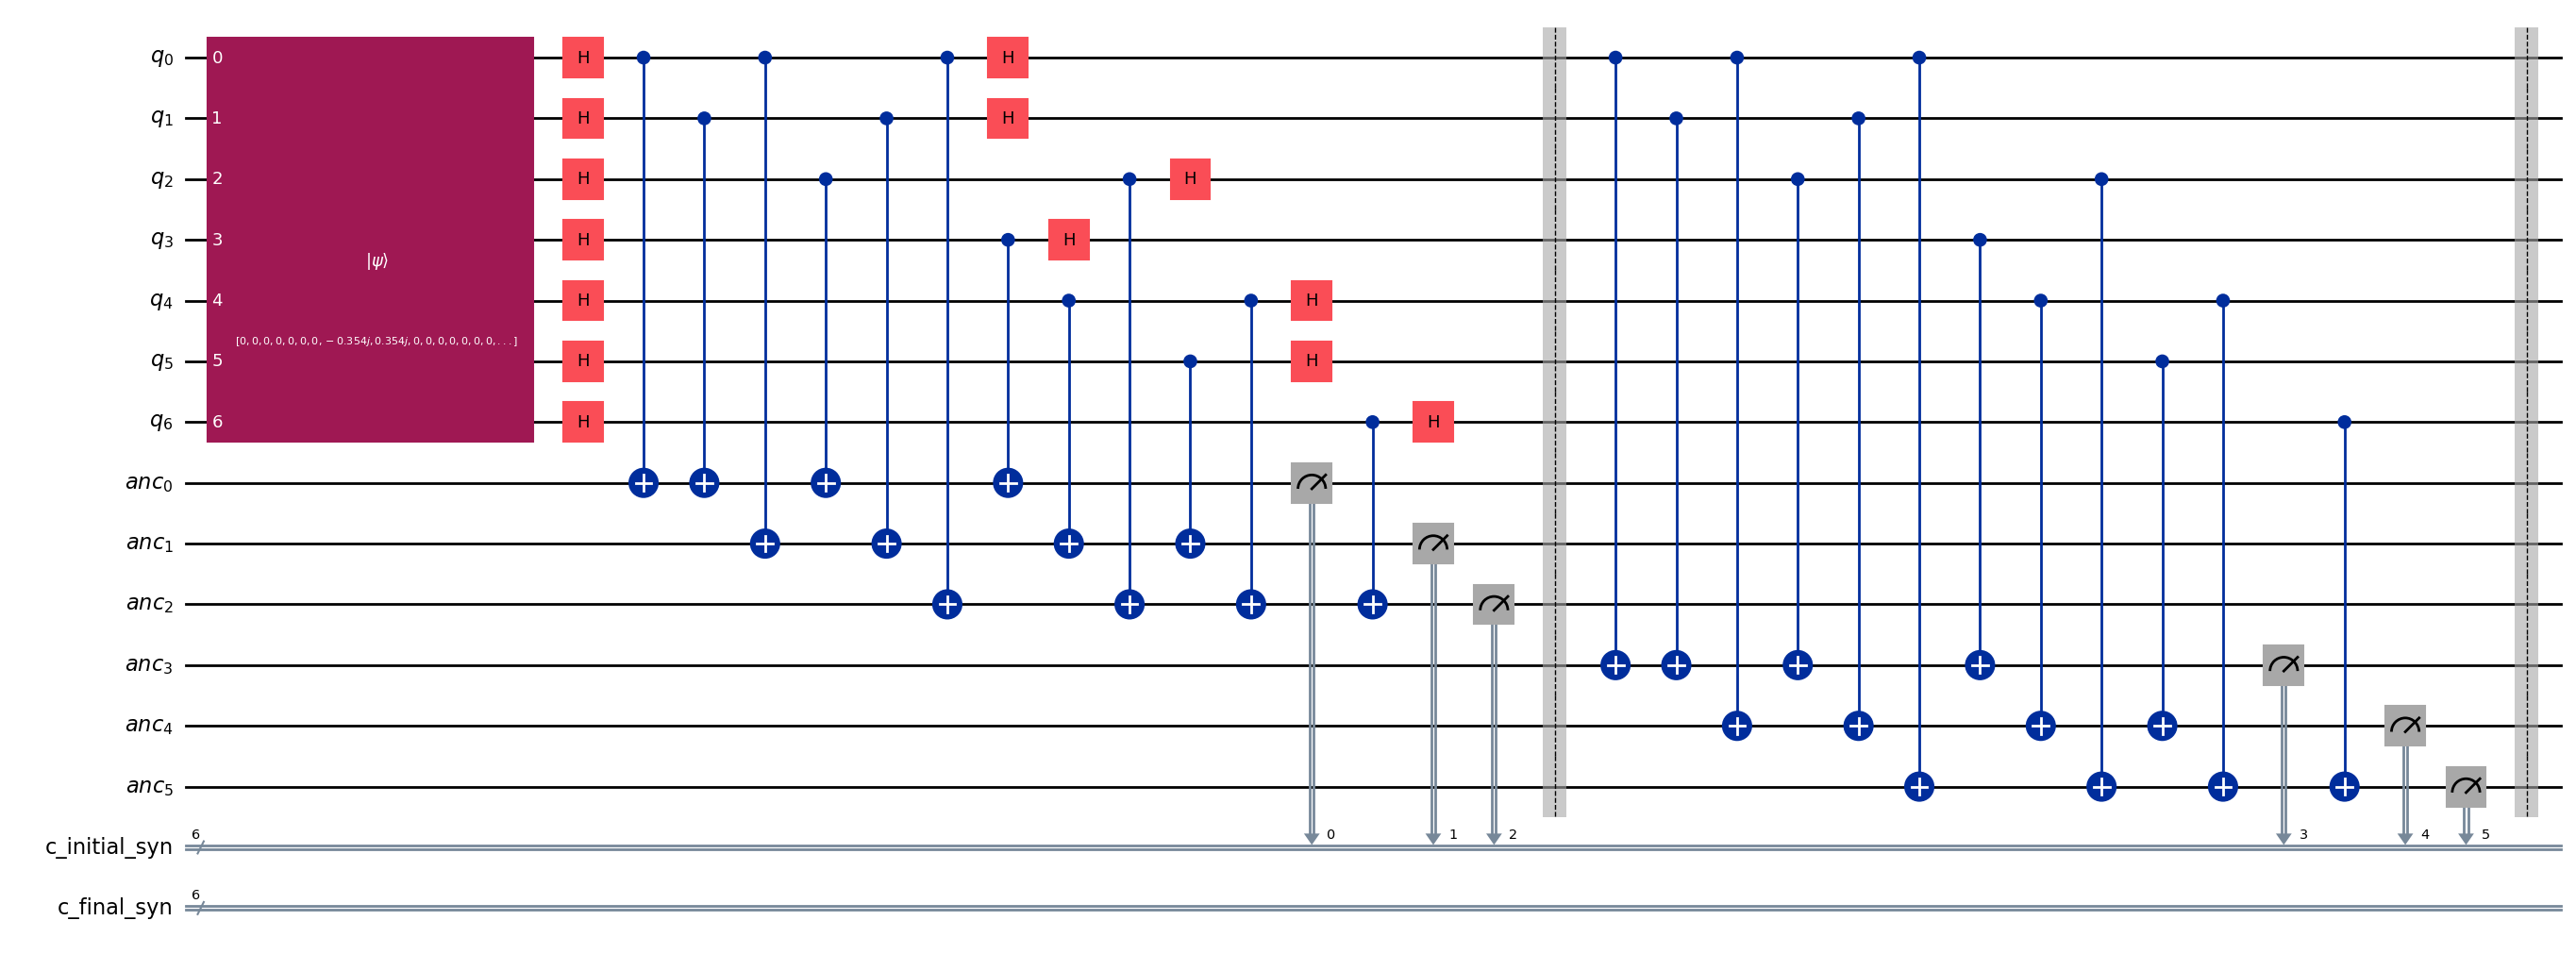

In [41]:
measure_steane_syndrome(qc, qr_data, qr_anc, cr_initial_syn)

qc.draw('mpl', fold=-1)

In [42]:
# --- Run the Simulation using AerSimulator
backend = AerSimulator()

#make quantum circuit compatible to the backend
pm = generate_preset_pass_manager( backend = backend, optimization_level=3)
qc_isa = pm.run(qc)

#run and get counts
sampler = Sampler(mode=backend)
counts = sampler.run([qc_isa], shots = 10000).result()[0].data.c_initial_syn.get_counts()

# ---- TODO : Task 3 ---
#get key of simulation result and find the error code, ex: X1
syndrome_key = max(counts, key=counts.get)
error_code = steane_decoder_syndrome_map.get(syndrome_key, "Unknown")
# --- End of TODO ---

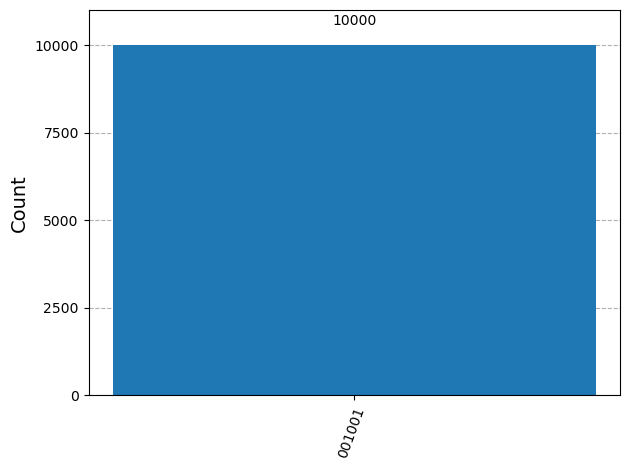

In [43]:
plot_histogram(counts)

In [44]:
grade_lab4_ex3(error_code)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [110]:
# Some helpful code to start Exercise 4.


# We will define the parity check matrices for the toric code
HXtc = np.zeros((72, 144),dtype=int) # initializing the matrices
HZtc = np.zeros((72, 144),dtype=int)

# We will ask you to modify the matrices by adding 1s in appropriate places
# As an example, we will show how to do so for the first few rows of the toric code


# ---- TODO : Task 4 ---
# Write code to calculate HXtc and HZtc

# 0-th stabilizer
HXtc[0][0] = 1
HXtc[0][1] = 1
HXtc[0][72] = 1
HXtc[0][138] = 1

# 1-st stabilizer
HXtc[1][1] = 1
HXtc[1][2] = 1
HXtc[1][73] = 1
HXtc[1][139] = 1

# 2-nd stabilizer
HXtc[2][2] = 1
HXtc[2][3] = 1
HXtc[2][74] = 1
HXtc[2][140] = 1

# 3-rd stabilizer
HXtc[3][3] = 1
HXtc[3][4] = 1
HXtc[3][75] = 1
HXtc[3][141] = 1

# 4-th stabilizer
HXtc[4][4] = 1
HXtc[4][5] = 1
HXtc[4][76] = 1
HXtc[4][142] = 1

# 5-th stabilizer
HXtc[5][5] = 1
HXtc[5][np.mod(6,6)] = 1
HXtc[5][72 + 5] = 1
HXtc[5][72 + 6*np.mod(-1,12) + 5] = 1

# The last definition suggested a general rule for finding the appropriate locations to place 1s
# HXtc[j][j] = 1
# HXtc[j][6*np.floor(j/6) + np.mod(j+1,6)]
# HXtc[j][j+72] = 1
# HXtc[j][72 + 6*np.mod(np.floor(j/6)-1,12) + np.mod(j,6)]

# Write a loop over j from 0 to 143 to set all of the rows.
for j in range(72):  # Only 72 stabilizers for X-type
    row = j
    col = j
    r = j // 6
    c = j % 6
    right = 6 * r + (c + 1) % 6
    down = j + 72
    left_up = 72 + 6 * ((r - 1) % 12) + c

    HXtc[row][col] = 1
    HXtc[row][right] = 1
    HXtc[row][down] = 1
    HXtc[row][left_up] = 1
# Inspired from this, write a similar loop for the Z parity check matrices and complete HXtc and HZtc
HZtc[0][0] = 1
HZtc[0][6] = 1
HZtc[0][72] = 1
HZtc[0][77] = 1
HZtc = np.zeros((72, 144), dtype=int)

cols = 12
rows = 6

# Z stabilizer index (i ranges from 0 to 71)
for j in range(72):
    HZtc[j][j] = 1
    HZtc[j][(j - 1) % 6 + 6 * (j//6) + 72] = 1
    HZtc[j][j + 72] = 1
    HZtc[j][6 * ((j//6 + 1) % 12) + (j % 6)] = 1
# --- End of TODO ---

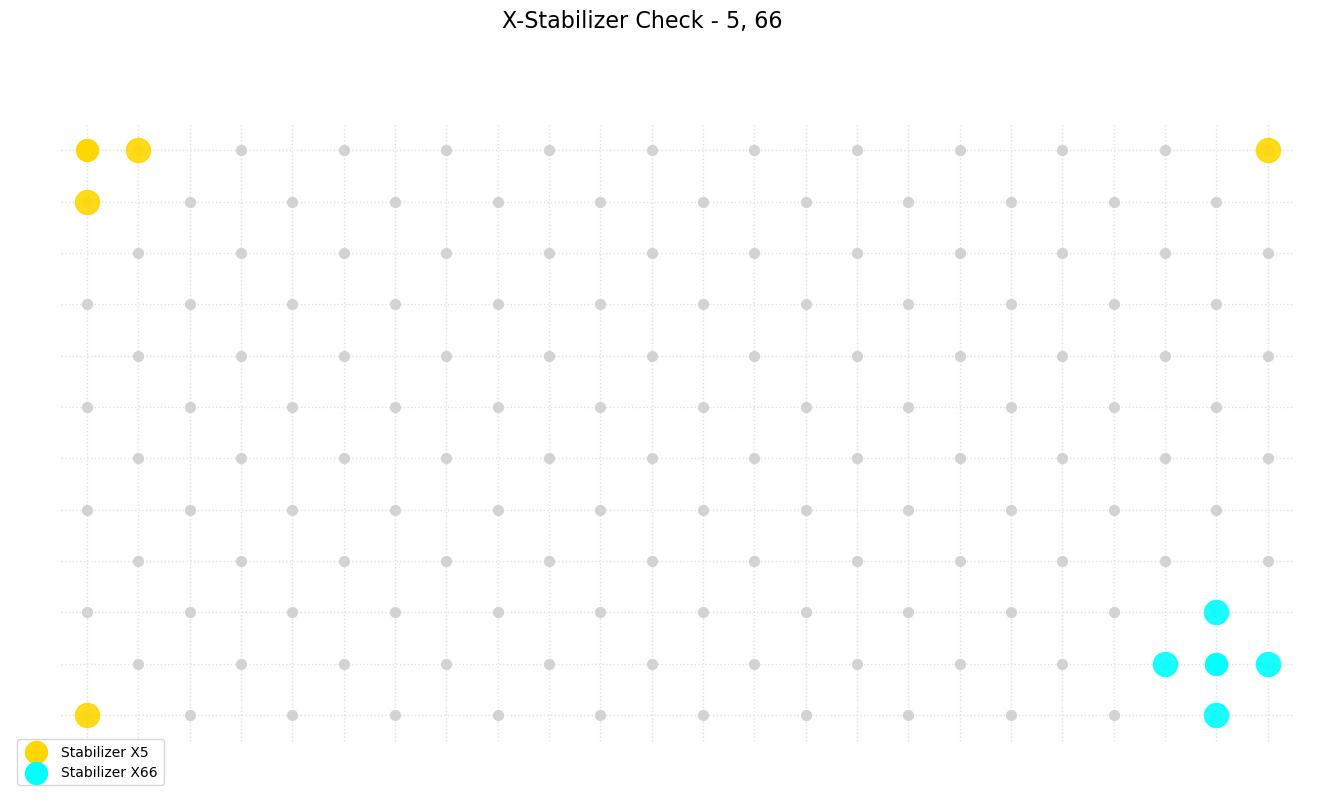

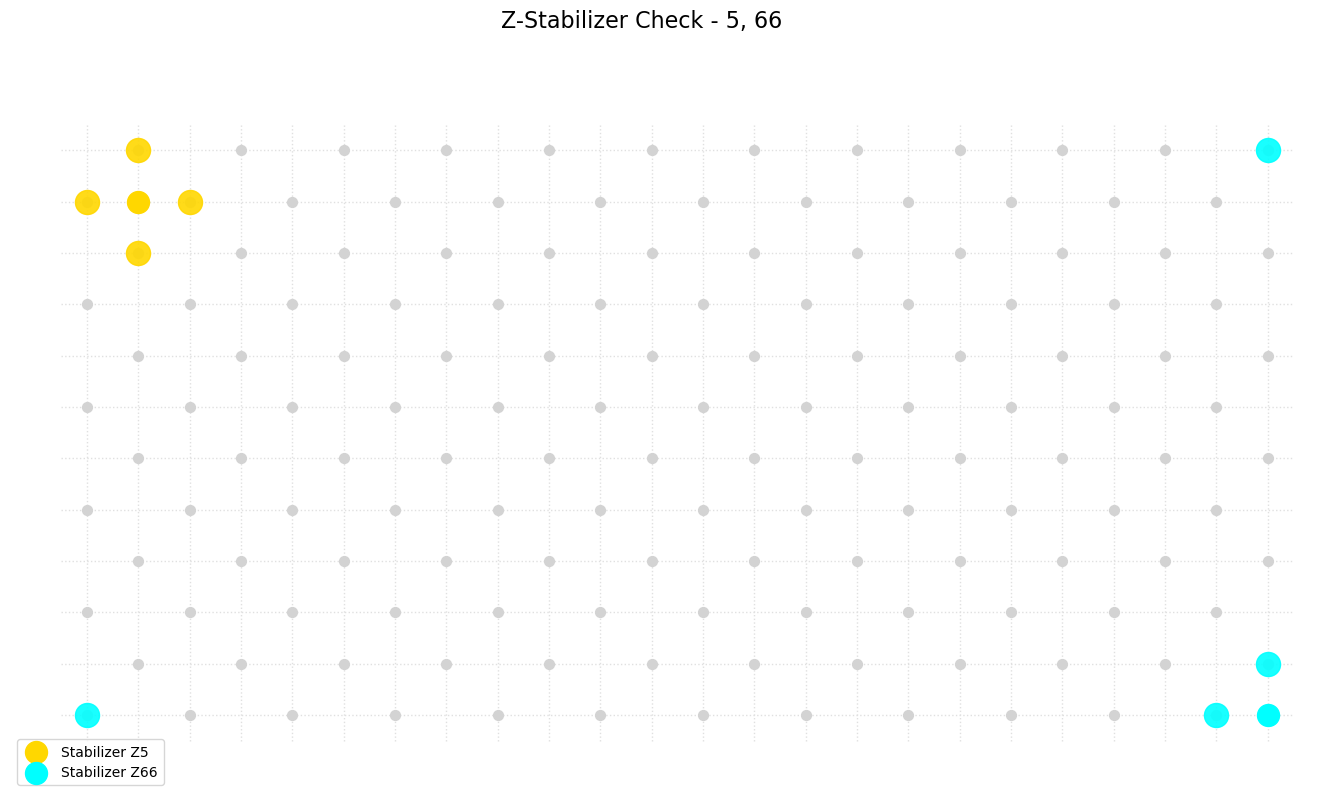

In [111]:
from lab4_util import generate_stabilizer_plots
generate_stabilizer_plots(HXtc, HZtc)

In [112]:
grade_lab4_ex4(HXtc, HZtc)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [129]:
# Exercise 5: Gross-code parity check matrices
# Initialize empty 72x144 arrays
HXgc = np.zeros((72, 144), dtype=int)
HZgc = np.zeros((72, 144), dtype=int)

# Loop over each of the 72 stabilizers arranged on a 12x6 torus
for j in range(72):
    col = j // 6
    row = j % 6

    # – Toric (nearest-neighbor) part –
    # X-check (star) neighbors:
    b0 = col*6 + row
    b1 = col*6 + (row+1) % 6
    o0 = 72 + col*6 + row
    o1 = 72 + ((col-1) % 12)*6 + row
    for idx in (b0, b1, o0, o1):
        HXgc[j, idx] = 1

    # Z-check (plaquette) neighbors:
    L = col*6 + row
    R = ((col+1) % 12)*6 + row
    B = 72 + col*6 + row
    T = 72 + col*6 + (row-1) % 6
    for idx in (L, R, B, T):
        HZgc[j, idx] = 1

    # – Gross “Leaf” edges –
    # X-leafs: blue at (+3 cols, +2 rows), orange at (−2 cols, +3 rows)
    bLR = ((col+3) % 12)*6 + ((row+2) % 6)
    oLR = 72 + ((col-2) % 12)*6 + ((row+3) % 6)
    HXgc[j, bLR] = 1
    HXgc[j, oLR] = 1

    # Z-leafs: blue at (+2 cols, +3 rows), orange at (−3 cols, +4 rows)
    bLRz = ((col+2) % 12)*6 + ((row+3) % 6)
    oLRz = 72 + ((col-3) % 12)*6 + ((row+4) % 6)
    HZgc[j, bLRz] = 1
    HZgc[j, oLRz] = 1

# Now HXgc and HZgc contain the full 6-weight rows for the gross code

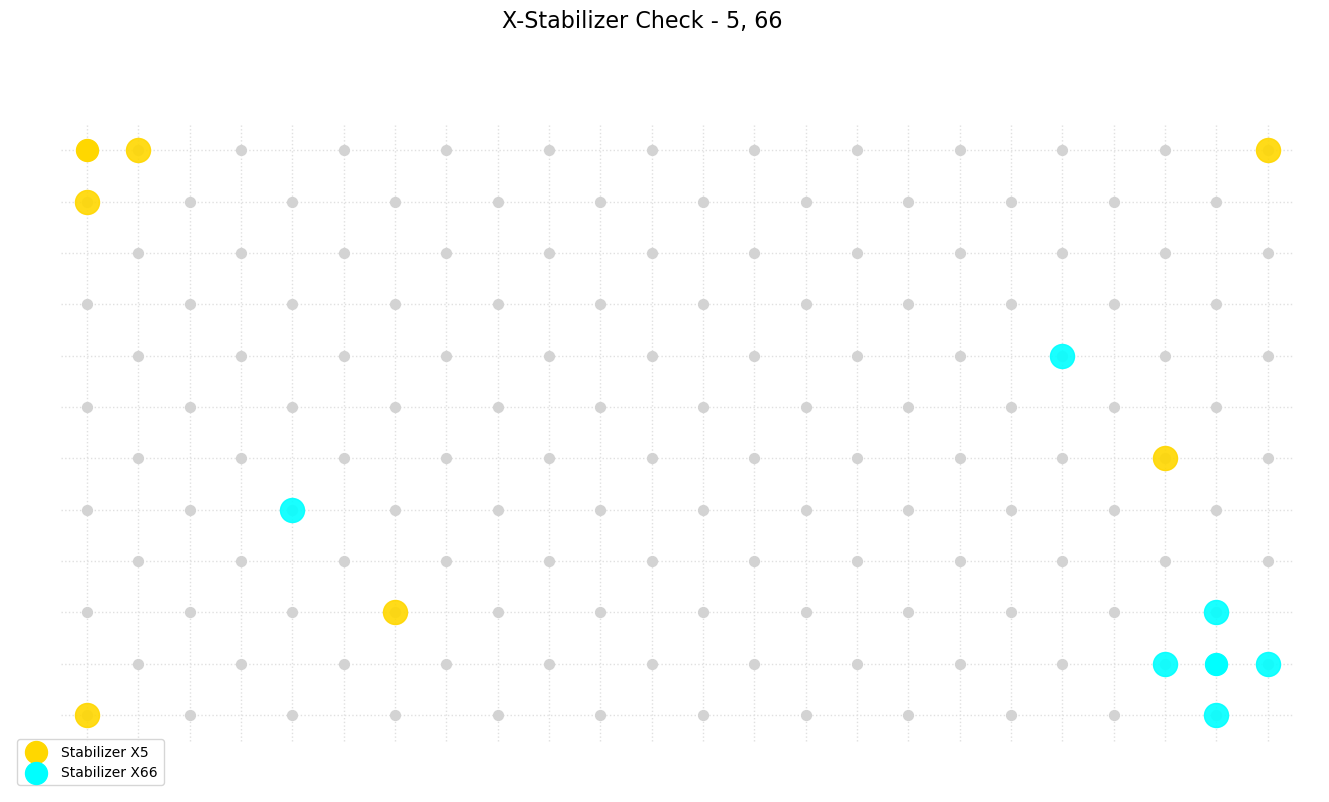

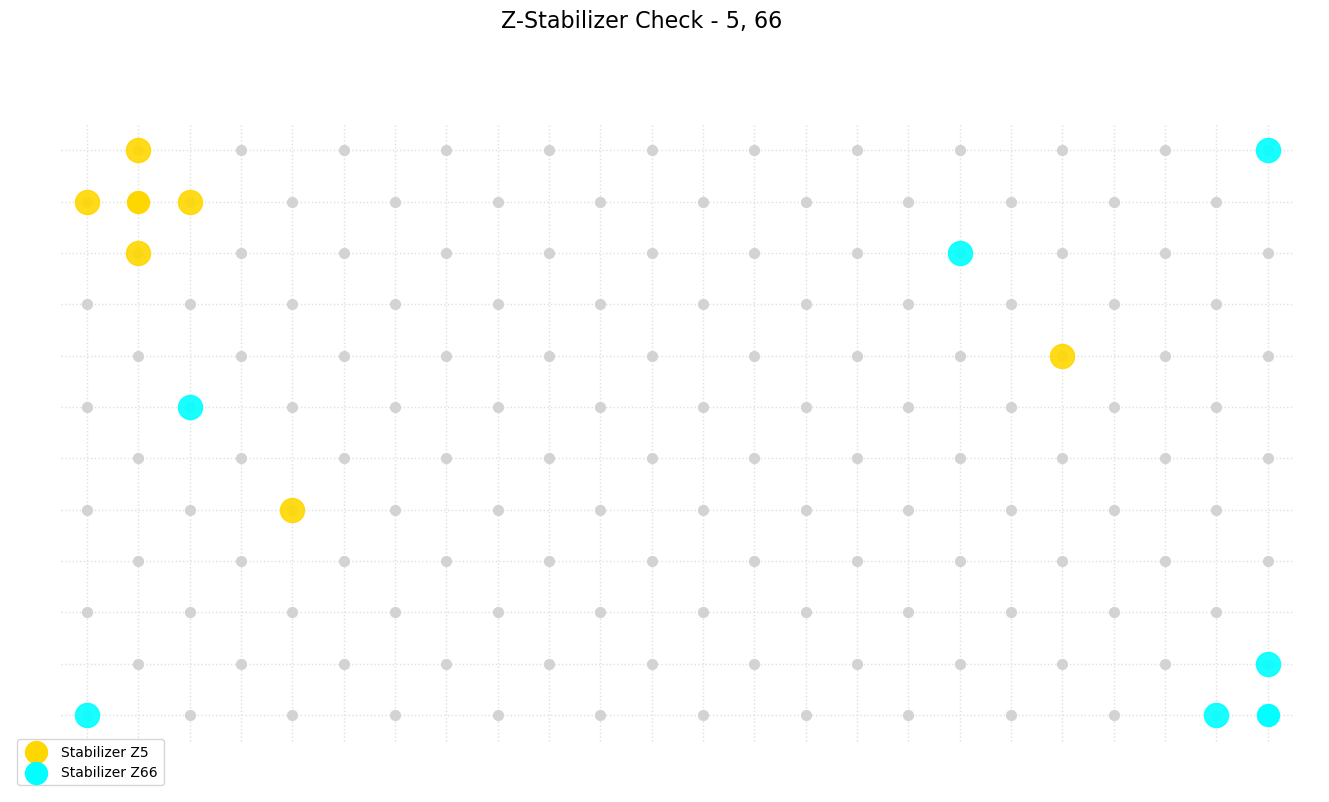

In [130]:
generate_stabilizer_plots(HXgc, HZgc)

In [131]:
grade_lab4_ex5(HXgc, HZgc)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [132]:
# ---- TODO : Task 6 ---
# Write code to calculate k_toric and k_gross
# Hint: You can use the matrixRank imported from lab4_utils

#toric code
rx_toric = matrixRank(HXtc)
rz_toric = matrixRank(HZtc)
k_toric = 144 - rx_toric - rz_toric

# gross code
rx_gross = matrixRank(HXgc)
rz_gross = matrixRank(HZgc)
k_gross = 144 - rx_gross - rz_gross
# --- End of TODO ---

In [133]:
grade_lab4_ex6(k_toric, k_gross)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [1]:
# Check your submission status with the code below
from qc_grader.grader.grade import check_lab_completion_status

check_lab_completion_status("qgss_2025")

Lab 0: 2/2 exercises completed (100%)
    ✅ 2209 participants have completed this lab
Lab 1: 9/9 exercises completed (100%)
    ✅ 1646 participants have completed this lab
Lab 2: 7/7 exercises completed (100%)
    ✅ 912 participants have completed this lab
Lab 3: 5/5 exercises completed (100%)
    ✅ 639 participants have completed this lab
Lab 4: 6/6 exercises completed (100%)
    ✅ 411 participants have completed this lab
Functions Labs: 0/8 exercises completed (0%)
    ✅ 2 participants have completed this lab
